# Initialisation

In [153]:
from __future__ import annotations
import numpy as np
from sympy.combinatorics import GrayCode
from collections.abc import Iterable
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.special import erfc
from commpy.filters import rrcosfilter
from commpy.utilities import upsample
from eyediagram.mpl import eyediagram


NUM_PAM_BITS = 1
PAM_OUTPUT_LOWER = -1
PAM_OUTPUT_UPPER = 1
SYMBOL_RATE_S = 2e-6
OVERSAMPLING_FACTOR = 8
CHANNEL_CUTOFF_HZ = 500e3
ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB = 10
EXAMPLE_USER_DATA = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0])

# Question D

## PAM Modulator

In [154]:
class PamModulator:
    output_lower: float
    output_upper: float
    code_length: int
    code_word_to_amplitude_map: dict[tuple[int, ...], float] = {}
    amplitude_to_code_word_map: dict[float, tuple[int, ...]] = {}

    def __init__(
        self, output_lower: float, output_upper: float, code_length: int
    ):
        self.output_lower = output_lower
        self.output_upper = output_upper
        self.code_length = code_length

        gray_code_strings = GrayCode(code_length).generate_gray()

        for code_i, code_string in enumerate(gray_code_strings):
            code = tuple(int(b) for b in code_string)
            amplitude = self.amplitude_from_code_index(
                code_i
            )
            self.code_word_to_amplitude_map[code] = amplitude
            self.amplitude_to_code_word_map[amplitude] = code


    def encode(self, input_signal: Iterable[int]) -> list[float]:
        partitioned_signal = self.split_signal_into_chunks_of_code_length(input_signal)

        result: list[float] = []
        for input_bitstring in partitioned_signal:
            result.append(self.code_word_to_amplitude_map[input_bitstring])

        return result
    
    def decode(self, received_signal: Iterable[float]) -> list[int]:
        decoded_signal = []
        for amplitude in received_signal:
            code_word = self.decode_symbol(amplitude)
            decoded_signal.extend(code_word)
        
        return decoded_signal

    def decode_symbol(self, symbol_amplitude: float) -> tuple[int, ...]:
        code_amplitudes = np.array(list(self.amplitude_to_code_word_map.keys()))
        closest_amplitude_i = np.abs(code_amplitudes - symbol_amplitude).argmin()
        closest_amplitude = code_amplitudes[closest_amplitude_i]

        code_word = self.amplitude_to_code_word_map[closest_amplitude]
        return code_word


    def split_signal_into_chunks_of_code_length(
        self, signal: Iterable[int]
    ) -> list[tuple[int, ...]]:
        partitioned_signal = np.split(
            signal, signal.size / self.code_length
        )

        result: list[tuple[int, ...]] = []
        for code_word in partitioned_signal:
            result.append(tuple(code_word))

        return result

    def amplitude_from_code_index(self, idx: int) -> float:
        amplitude = np.interp(
            idx, [0, 2**self.code_length - 1], [self.output_lower, self.output_upper]
        )

        return amplitude
    
    def compute_bit_energy(self):
        code_amplitudes = np.array(list(self.code_word_to_amplitude_map.values()))
        code_energy = np.sum(np.square(code_amplitudes))

        bit_energy = code_energy / (code_amplitudes.size * self.code_length)
        return bit_energy

## Raised-Cosine Filter 

In [155]:
class RaisedCosineFilter:
    symbol_period: float
    resolution: int
    impulse_response: np.array[float]
    impulse_time: np.array[float]

    def __init__(
        self, symbol_period: float, roll_off_factor: float=0.5, resolution=50, window_length:float=6
    ) -> RaisedCosineFilter:
        """
        @param resolution the number of samples per symbol
        @param window_length the length of the impulse response window in symbol periods
        """
        self.symbol_period = symbol_period
        self.resolution = resolution
        self.impulse_time, self.impulse_response = rrcosfilter(window_length * self.resolution, roll_off_factor, symbol_period, resolution / symbol_period)
        impulse_response_energy = np.sum(np.square(self.impulse_response))
        self.impulse_response /= np.sqrt(impulse_response_energy)
        print(np.sum(np.square(self.impulse_response)))

    def filter(
        self, input_signal: Iterable[float]
    ) -> tuple[np.ndarray[np.float], np.ndarray[np.float]]:
        
        convolution_input = upsample(input_signal, self.resolution)
        
        output_values = np.convolve(convolution_input, self.impulse_response)

        time_values = np.arange(len(output_values)) * self.symbol_period / self.resolution + self.impulse_time.min()

        return time_values, output_values

    def unfilter(
        self, filtered_signal: np.ndarray[np.float]
    ) -> np.ndarray[np.float]:
        # Compute the time-reversed impulse response
        time_reversed_impulse_response = self.impulse_response[::-1]

        # Convolve the filtered signal with the time-reversed impulse response
        unfiltered_signal = np.convolve(filtered_signal, time_reversed_impulse_response, mode="same")

        # Return the unfiltered signal
        return unfiltered_signal

In [156]:
pam_signal_encoder = PamModulator(PAM_OUTPUT_LOWER, PAM_OUTPUT_UPPER, NUM_PAM_BITS)

pam_encoded_example_signal = pam_signal_encoder.encode(EXAMPLE_USER_DATA)
pam_encoded_example_signal

[1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0]

0.12504590806469093


/home/llamington/Documents/ENEL422-Lab/venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/llamington/Documents/ENEL422-Lab/venv/lib/python3.8/site-packages/numpy/ma/core.py:3375: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


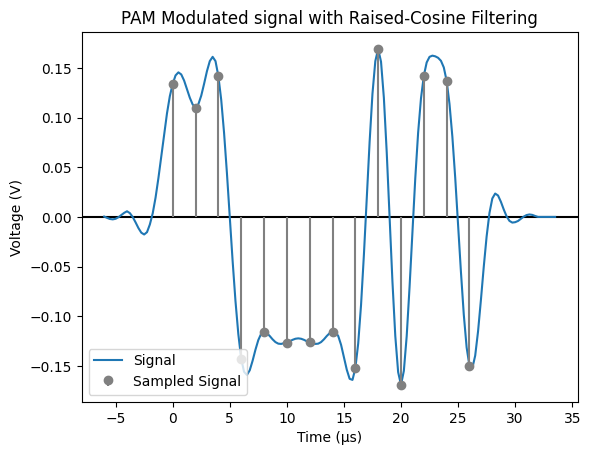

In [157]:
raised_cosine_filter = RaisedCosineFilter(SYMBOL_RATE_S, 0.5, OVERSAMPLING_FACTOR, 6)
time, filtered_example_signal = raised_cosine_filter.filter(pam_encoded_example_signal)
time_us = time * 1e6

fig, ax = plt.subplots()

ax.axhline(color="black")
ax.plot(time_us, filtered_example_signal, label="Signal")
ax.set_title("PAM Modulated signal with Raised-Cosine Filtering")
ax.set_ylabel("Voltage (V)")
ax.set_xlabel("Time (μs)")

region_of_interest = (time >= 0) & (time < SYMBOL_RATE_S * len(pam_encoded_example_signal))
sampling_times_us = time_us[region_of_interest][::OVERSAMPLING_FACTOR]
sampled_amplitudes = filtered_example_signal[region_of_interest][::OVERSAMPLING_FACTOR]

ax.stem(sampling_times_us, sampled_amplitudes, label="Sampled Signal", linefmt="grey", basefmt=' ')
ax.legend();

# Question E

In [158]:
class BandLimitedChannel:
    cutoff_frequency: float
    rng: np.random.Generator

    def __init__(self, cutoff_frequency: float, sample_spacing: float, noise_power: float, rng_seed: int | None=None):
        self.cutoff_frequency = cutoff_frequency
        self.sample_spacing = sample_spacing
        self.noise_power = noise_power
        self.rng = np.random.default_rng(rng_seed)

    def transmit_signal(self, signal: Iterable[float]) -> np.ndarray[float]:
        signal_spectrum = fft(signal)
        frequencies = fftfreq(len(signal), self.sample_spacing)

        passband_mask = frequencies <= self.cutoff_frequency

        signal_spectrum_filtered = signal_spectrum.copy()
        signal_spectrum_filtered[~passband_mask] = 0

        signal_filtered = ifft(signal_spectrum_filtered)

        awg_noise = np.sqrt(self.noise_power) * self.rng.standard_normal(len(signal))

        noisy_signal = np.real(signal_filtered) + awg_noise
        return noisy_signal

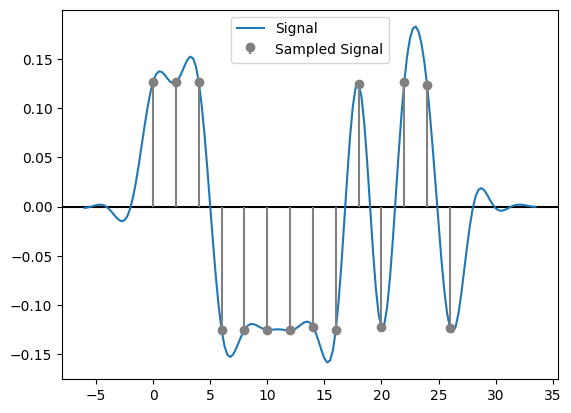

In [159]:
unfiltered_example_signal = raised_cosine_filter.unfilter(filtered_example_signal)
fig, ax = plt.subplots()
ax.axhline(color="black")
ax.plot(time_us, unfiltered_example_signal, label="Signal")

region_of_interest = (time >= 0) & (time < SYMBOL_RATE_S * len(pam_encoded_example_signal))
sampling_times_us = time_us[region_of_interest][::OVERSAMPLING_FACTOR]
sampled_amplitudes = unfiltered_example_signal[region_of_interest][::OVERSAMPLING_FACTOR]

ax.stem(sampling_times_us, sampled_amplitudes, label="Sampled Signal", linefmt="grey", basefmt=' ')
ax.legend();

/tmp/ipykernel_24773/3999684487.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(-2, 2, 0.5))


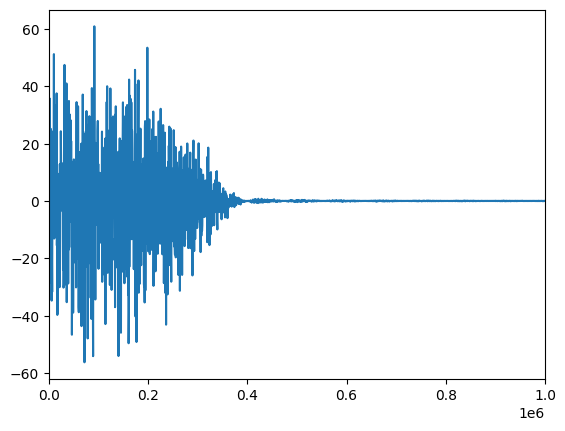

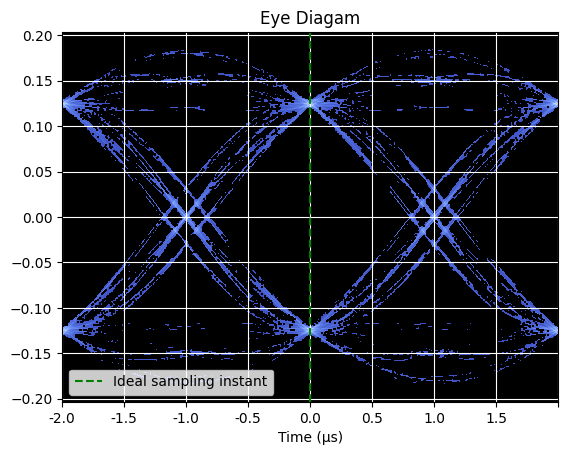

In [160]:
eye_diagram_input_signal = np.random.randint(0, 2, 1_000)
pam_encoded_eye_diagram_signal = pam_signal_encoder.encode(eye_diagram_input_signal)
time, eye_diagram_filtered_signal = raised_cosine_filter.filter(pam_encoded_eye_diagram_signal)

band_limited_channel = BandLimitedChannel(CHANNEL_CUTOFF_HZ, SYMBOL_RATE_S/OVERSAMPLING_FACTOR, 0)

eye_diagram_band_limited_signal = band_limited_channel.transmit_signal(eye_diagram_filtered_signal)

unfiltered_signal = raised_cosine_filter.unfilter(eye_diagram_band_limited_signal)

fig, ax = plt.subplots()

eyediagram(unfiltered_signal, 2 * OVERSAMPLING_FACTOR, colorbar=False, aspect="auto", cmap=plt.cm.coolwarm)

ax.set_xticklabels(np.arange(-2, 2, 0.5))

ax.axvline(1, color="green", linestyle='dashed', label="Ideal sampling instant")
ax.set_title("Eye Diagam")
ax.set_xlabel("Time (μs)")
ax.legend(loc="lower left");

## Question F

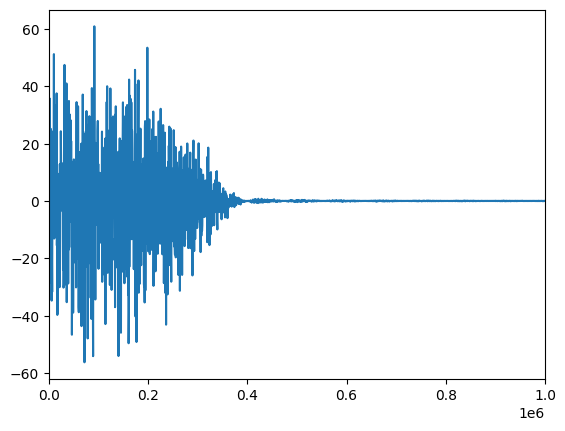

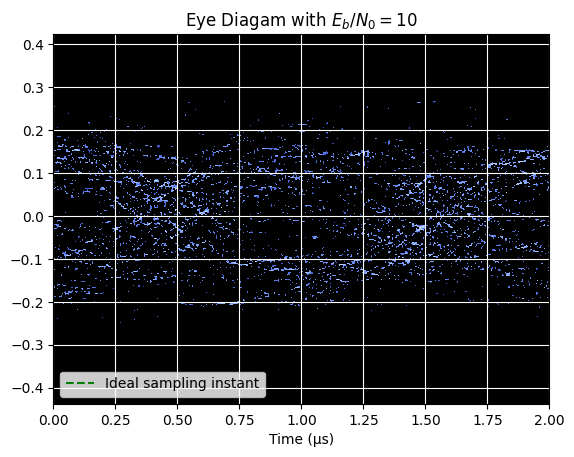

In [161]:
bit_energy_joules = pam_signal_encoder.compute_bit_energy()
energy_per_bit_to_noise_power_spectral_density_watts = 10 ** (ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB / 10)
noise_power_watts = 1 / (2 * energy_per_bit_to_noise_power_spectral_density_watts)

band_limited_channel = BandLimitedChannel(CHANNEL_CUTOFF_HZ, SYMBOL_RATE_S/OVERSAMPLING_FACTOR, noise_power_watts)

eye_diagram_band_limited_signal = band_limited_channel.transmit_signal(eye_diagram_filtered_signal)

unfiltered_signal = raised_cosine_filter.unfilter(eye_diagram_band_limited_signal)

fig, ax = plt.subplots()

eyediagram(unfiltered_signal, 2 * OVERSAMPLING_FACTOR, colorbar=False, aspect="auto", cmap=plt.cm.coolwarm)

# for sampling_time in np.linspace(0, (len(pam_encoded_eye_diagram_signal)-1) * SYMBOL_RATE_S, len(pam_encoded_eye_diagram_signal)):
#     sampling_index = np.abs(time - sampling_time_s).argmin()
#     signal_amplitude_at_sampling_time = unfiltered_signal[sampling_index]
#     ax.plot(time - sampling_time, unfiltered_signal, color="blue", alpha=0.1)

# ax.set_xlim(0, 2 * SYMBOL_RATE_S)
ax.axvline(0, color="green", linestyle='dashed', label="Ideal sampling instant")
ax.set_title(f"Eye Diagam with $E_b/N_0 = {ENERGY_PER_BIT_TO_NOISE_POWER_SPECTRAL_DENSITY_DB}$")
ax.set_xlabel("Time (μs)")
ax.legend(loc="lower left");

## Question H

303
290
275
262
256
243
233
227
211
203
194
179
160
151
133
118
103
90
73
61


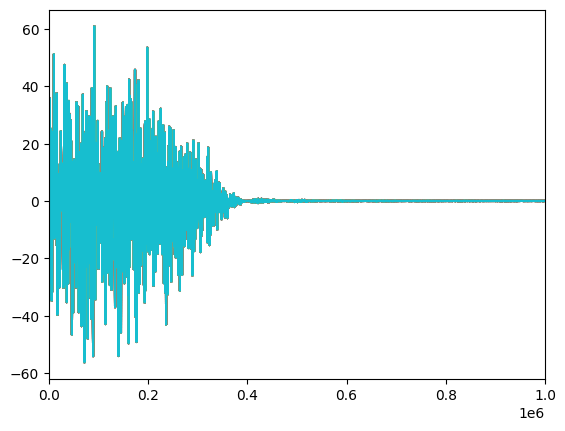

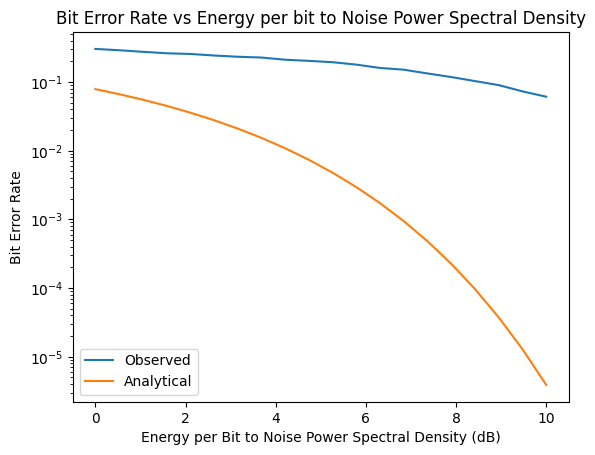

In [162]:
noise_spectral_densities_db = np.linspace(0, 10, 20)
observed_bit_error_rates = []
analytical_bit_error_rates = []
for energy_per_bit_to_noise_spectral_density_db in noise_spectral_densities_db:
    energy_per_bit_to_noise_power_spectral_density_watts = 10 ** (energy_per_bit_to_noise_spectral_density_db / 10)
    noise_power_watts = 1 / (2 * energy_per_bit_to_noise_power_spectral_density_watts)
    band_limited_channel = BandLimitedChannel(CHANNEL_CUTOFF_HZ, SYMBOL_RATE_S/OVERSAMPLING_FACTOR, noise_power_watts, 0)
    band_limited_signal = band_limited_channel.transmit_signal(eye_diagram_filtered_signal)
    unfiltered_signal = raised_cosine_filter.unfilter(band_limited_signal)

    region_of_interest = (time >= 0) & (time < SYMBOL_RATE_S * len(pam_encoded_eye_diagram_signal))
    sampled_amplitudes = unfiltered_signal[region_of_interest][::OVERSAMPLING_FACTOR]
    decoded_signal = pam_signal_encoder.decode(sampled_amplitudes)
    bit_error_count = np.count_nonzero(np.not_equal(decoded_signal, eye_diagram_input_signal))
    observed_bit_error_rates.append(bit_error_count / len(eye_diagram_input_signal))
    print(bit_error_count)

    analytical_bit_error_rate = 0.5 * erfc(np.sqrt(energy_per_bit_to_noise_power_spectral_density_watts))
    analytical_bit_error_rates.append(analytical_bit_error_rate)
                            
fig, ax = plt.subplots()

ax.plot(noise_spectral_densities_db, observed_bit_error_rates, label="Observed")
ax.plot(noise_spectral_densities_db, analytical_bit_error_rates, label="Analytical")
ax.set_yscale("log", base=10)

ax.set_ylabel("Bit Error Rate")
ax.set_xlabel("Energy per Bit to Noise Power Spectral Density (dB)")
ax.set_title("Bit Error Rate vs Energy per bit to Noise Power Spectral Density")
ax.legend();